# Unity ML-Agents Toolkit
## Environment Basics
This notebook contains a walkthrough of the basic functions of the Python API for the Unity ML-Agents toolkit. For instructions on building a Unity environment, see [here](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Getting-Started-with-Balance-Ball.md).

In [1]:
!pip3 install -q ./ml-agents/ml-agents
!pip3 install -q tensorflow==2.0.0-alpha0

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
mlagents 0.7.0 has requirement tensorflow<1.8,>=1.7, but you'll have tensorflow 2.0.0a0 which is incompatible.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 1. Import libraries

Import the libraries that are needed for loading the environment. The following loads the necessary dependencies and checks the Python version (at runtime). ML-Agents Toolkit (v0.3 onwards) requires Python 3.

### 3. Start the environment
`UnityEnvironment` launches and begins communication with the environment when instantiated.

Environments contain _brains_ which are responsible for deciding the actions of their associated _agents_. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [25]:
import os
import sys
import numpy as np
from mlagents.envs import UnityEnvironment

env_name = "./env/mac/Breakout" 
env = UnityEnvironment(file_name=env_name)

### 4. Examine the observation and state spaces
We can reset the environment to be provided with an initial set of observations and states for all the agents within the environment. In ML-Agents, _states_ refer to a vector of variables corresponding to relevant aspects of the environment for an agent. Likewise, _observations_ refer to a set of relevant pixel-wise visuals for an agent.

In [13]:
# Set the default brain to work with
default_brain = env.brain_names[0]

# Reset the environment
env_info = env.reset(train_mode=True)[default_brain]
state = env_info.vector_observations[0]
state_size = len(state)

brain = env.brains[default_brain]
# action_size = brain.vector_action_space_size[0]
action_size = int(brain.vector_action_space_size[0])

print('Number of agents:', len(env_info.agents))
print('Number of actions:', action_size)
print('States look like:', state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 3
States look like: [ 0.          0.         -0.3283889   5.99100637  0.          0.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.        ]
States have length: 54


### 5. Take random actions in the environment
Once we restart an environment, we can step the environment forward and provide actions to all of the agents within the environment. Here we simply choose random actions based on the `action_space_type` of the default brain. 

Once this cell is executed, 10 messages will be printed that detail how much reward will be accumulated for the next 10 episodes. The Unity environment will then pause, waiting for further signals telling it what to do next. Thus, not seeing any animation is expected when running this cell.

In [15]:
def trial(runs):
    for episode in range(runs):
        env_info = env.reset(train_mode=False)[default_brain]
        done = False
        episode_rewards = 0
        while not done:
            action_size = brain.vector_action_space_size
            if brain.vector_action_space_type == 'continuous':
                action = np.random.randn(len(env_info.agents), action_size)
                env_info = env.step(action)[default_brain]
            else:
                action = np.column_stack([np.random.randint(0, action_size)])
                env_info = env.step(action)[default_brain]
            episode_rewards += env_info.rewards[0]
            done = env_info.local_done[0]
        print("Total reward this episode: {}".format(episode_rewards))
        
# trial(1)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PTModel(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.hidden1 = nn.Linear(state_size, 200)
        self.hidden2 = nn.Linear(200, 200)
        self.hidden3 = nn.Linear(200, 200)
        self.q_state = nn.Linear(200, action_size)
        nn.init.xavier_normal_(self.hidden1.weight)
        nn.init.xavier_normal_(self.hidden2.weight)
        nn.init.xavier_normal_(self.hidden3.weight)
        nn.init.xavier_normal_(self.q_state.weight)

    def forward(self, state):
        hidden1 = F.relu(self.hidden1(state))
        hidden2 = F.relu(self.hidden2(hidden1)) + hidden1
        hidden3 = F.relu(self.hidden3(hidden2)) + hidden2
        q_state = self.q_state(hidden3)
        return q_state

class PTQNetwork():
    def __init__(self, state_size, action_size, load=False):
        self.model_local = PTModel(state_size, action_size)
        self.model_target = PTModel(state_size, action_size)
        self.optimizer = optim.Adam(self.model_local.parameters(), lr=0.0001, weight_decay=1e-4)
        if load: self.load_model()

    def get_q_state(self, state, use_target=False):
        model = self.model_local if not use_target else self.model_target
        state = torch.from_numpy(np.array(state)).float()
        return model(state).detach().numpy()
    
    def get_loss(self, states, actions, q_targets):
        states = torch.from_numpy(np.vstack(states)).float()
        actions = torch.from_numpy(np.vstack(actions)).long()
        q_targets = torch.from_numpy(np.vstack(q_targets)).float()
        q_states_actions = self.model_local(states).gather(1, actions)
        loss = (q_states_actions - q_targets)**2
        return loss.mean()
    
    def optimize(self, states, actions, q_targets):
        loss = self.get_loss(states, actions, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_copy(self.model_local, self.model_target)
        
    def soft_copy(self, local, target, tau=0.001):
        for l,t in zip(local.parameters(), target.parameters()):
            t.data.copy_(t.data + tau*(l.data - t.data))
        
    def save_model(self, filepath="./saved_models/torch/checkpoint.pth"):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        torch.save(self.model_local.state_dict(), filepath)
        
    def load_model(self, filepath="./saved_models/torch/checkpoint.pth"):
        if os.path.exists(filepath):
            self.model_local.load_state_dict(torch.load(filepath))
            self.model_target.load_state_dict(torch.load(filepath))

In [30]:
import tensorflow as tf
print("Tensorflow:", tf.__version__)

class TFModel(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.hidden1 = tf.keras.layers.Dense(200, activation=tf.nn.relu,
            kernel_initializer=tf.initializers.glorot_normal())
        self.hidden2 = tf.keras.layers.Dense(200, activation=tf.nn.relu,
            kernel_initializer=tf.initializers.glorot_normal(),
            kernel_regularizer=tf.keras.regularizers.l2(l=1e-2))
        self.hidden3 = tf.keras.layers.Dense(200, activation=tf.nn.relu,
            kernel_initializer=tf.initializers.glorot_normal(),
            kernel_regularizer=tf.keras.regularizers.l2(l=1e-6))
        self.q_state = tf.keras.layers.Dense(action_size
            kernel_initializer=tf.initializers.glorot_normal())
        
    def call(self, state):
        hidden1 = self.hidden1(state)
        hidden2 = self.hidden2(hidden1) + hidden1
        hidden3 = self.hidden3(hidden2) + hidden2
        q_state = self.q_state(hidden3)
        return q_state
    
class TFQNetwork():
    def __init__(self, state_size, action_size, load=False):
        self.model_local = TFModel(state_size, action_size)
        self.model_target = TFModel(state_size, action_size)
        self.optimizer = tf.optimizers.Adam(learning_rate=0.0001)
        self.action_size = action_size
        if load: self.load_model()
        
    def get_q_state(self, state, use_target=False):
        model = self.model_local if not use_target else self.model_target
        return model(np.array(state)).numpy()
    
    def get_loss(self, states, actions, q_targets):
        actions_one_hot = tf.one_hot(actions, depth=self.action_size)
        q_states = tf.cast(self.model_local(states), tf.float32)
        q_states_actions = tf.reduce_sum(tf.multiply(q_states, actions_one_hot), axis=1)
        loss = tf.reduce_sum(tf.square(q_states_actions - q_targets))
        return loss
    
    def optimize(self, states, actions, q_targets):
        loss = lambda: self.get_loss(states, actions, q_targets)
        self.optimizer.minimize(loss=loss, var_list=self.model_local.trainable_weights)
        self.soft_copy(self.model_local, self.model_target)
        
    def soft_copy(self, local, target, tau=0.001):
        new_target_vars = [t + tau*(l-t) for l,t in zip(local.get_weights(), target.get_weights())]
        self.model_target.set_weights(new_target_vars)
        
    def save_model(self, filepath="./saved_models/tf2/model.tf"):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        self.model_local.save_weights(filepath)
        
    def load_model(self, filepath="./saved_models/tf2/model.tf"):
        if os.path.exists(filepath + ".index"):
            self.model_local.load_weights(filepath)
            self.model_target.load_weights(filepath)

Tensorflow: 2.0.0-alpha0


In [18]:
from collections import deque
import random

class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

In [19]:
class DQNAgent():
    def __init__(self, state_size, action_size, eps=1.0, load=False):
        self.state_size = state_size
        self.action_size = action_size
        self.q_network = PTQNetwork(state_size, action_size, load)
        self.replay_buffer = ReplayBuffer(1000000)
        self.eps = eps
        self.gamma = 0.99

    def get_action(self, state, eps=None):
        eps = self.eps if eps == None else eps
        action_greedy = np.argmax(self.q_network.get_q_state([state]))
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < eps else action_greedy
        return action
        
    def train(self, state, action, next_state, reward, done):
        self.replay_buffer.add((state, action, next_state, reward, done))
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(32)
        
        next_actions = np.argmax(self.q_network.get_q_state(next_states, use_target=False), axis=1)
        q_next_states = self.q_network.get_q_state(next_states, use_target=True)
        q_next_states[dones] = np.zeros([self.action_size])
        q_next_states_next_actions = q_next_states[np.arange(next_actions.shape[0]), next_actions]
        q_targets = rewards + self.gamma * q_next_states_next_actions
        self.q_network.optimize(states, actions, q_targets)

        if done: self.eps = max(self.eps * 0.998, 0.1)

In [36]:
agent = DQNAgent(state_size, action_size, eps=1.0, load=False)
num_episodes = 1000
scores_buffer = deque(maxlen=100)
scores = []
avg_scores = []

for ep in range(num_episodes):
    #train_mode = (ep % 100) > 3 || (ep % 100) < 97
    env_info = env.reset(train_mode=True)[default_brain]
    state = env_info.vector_observations[0]
    total_reward = 0
    done = False
    while not done:
        action = agent.get_action(state)
        env_info = env.step(action)[default_brain]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]  
        agent.train(state, action, next_state, reward, done)
        total_reward += reward  
        state = next_state 

    scores.append(total_reward)
    scores_buffer.append(total_reward)
    avg_scores.append(np.mean(scores_buffer))
    print("Episode: {}, Score: {}, Avg reward: {:.2f}".format(ep, scores[-1], avg_scores[-1]))

agent.q_network.save_model()

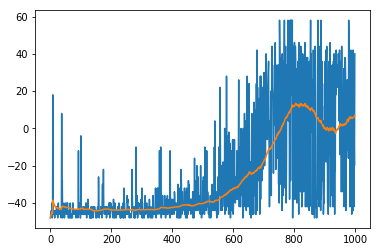

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline

x = range(len(scores))
plt.plot(x,scores, x,avg_scores)

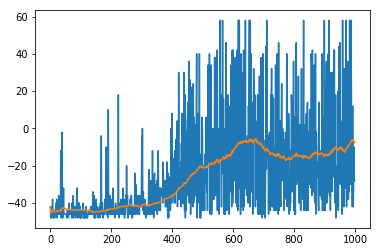

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

x = range(len(scores))
plt.plot(x,scores, x,avg_scores)

In [140]:
test_agent = DQNAgent(state_size, action_size, load=True)

for ep in range(1):
    env_info = env.reset(train_mode=False)[default_brain]
    state = env_info.vector_observations[0]
    total_reward = 0
    done = False
    while not done:
        action = test_agent.get_action(state, eps=0.0)
        env_info = env.step(action)[default_brain]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        total_reward += reward  
        state = next_state 
    print("Episode: {}, Score: {}".format(ep, total_reward))

Episode: 0, Score: -18.0


### 6. Close the environment when finished
When we are finished using an environment, we can close it with the function below.

In [24]:
env.close()